# To Do

- Implement intial densities  (now just set to 0), make sure that upper and lower boundary are set to 0.
- Implement pressure gradient (hence for in x direction) (In forcing function)
- Implement # of iterations dependence on relaxation time
- for loop in velocity determinations needs to be replaced by other less time consuming mechanism
- In BC np.argwhere niet gebruiken
- Split in seperate files
- Namespace for results (needed for data processing)
- Add movie
- Initialisation of densities --> Arbitrary (x)
- Add docstrings (x)
- Imaging in seperate function (x)
- Implement velocity spectrum (x)

In [587]:
import numpy as np
from sys import exit 
from types import SimpleNamespace
import matplotlib.pyplot as plt

def plot_boltzmann_lattice(self, par):
    """ Plot of 2D boltzman lattice with velocity profile over entire lattice
    
    Parameters
    ----------
    self : NameSpace
        simulation constants
    par: NameSpace
        containing parameter arrays
        
    Returns
    -------
    plots of system (UPDATE THIS DESCRIPTION!!!!!!!)
        
    """
    
    plt.subplot(1, 2, 1)
    plt.imshow(par.u[:, 1:sim.W_in, 1])
    plt.xlabel('xlabel')
    plt.ylabel('ylabel')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(abs(par.u[:, 1:sim.W_in, 0]))
    plt.xlabel('xlabel')
    plt.ylabel('ylabel')
    plt.colorbar()
    plt.show()
    

def plot_velocity_profile(self, par):
    """ Plot of velocity profile over the width of the lattice
    
    Parameters
    ----------
    self : NameSpace
        simulation constants
    par: NameSpace
        containing parameter arrays
        
    Returns
    -------
    plots of system (UPDATE THIS DESCRIPTION!!!!!!!)
        
    """
    x_axis = np.arange(self.W_in)
    plt.plot(x_axis,par.u[0,1:self.W_in,1])
    plt.xlabel('Width')
    plt.ylabel('Velocity')
    plt.title('Velocity profile at t = ...')
    plt.show()
    
def boltzmann_sim(self):
    """ Simulation of the boltzmann lattice
    
    Parameters
    ----------
    self : NameSpace
        simulation constants 
        
    Returns
    -------
    par: NameSpace
        containing parameter arrays
        
    """
    
    input_check(self)
    sim, par = initialization(self)
    
    for i in range(sim.iterations):
        par = shift_n(self, par)
        par = boundary_bounch(self, par)
        par = velocity(self, par)
        par = forcing(self, par)
        par = eq_n(self, par)
        par = relax_n(self, par)
        
    plot_boltzmann_lattice(sim, par)
    
    return par

def input_check(self):
    """ Checks imput constants and gives an error when width, height or res have wrong values
    
    Parameters
    ----------
    self : NameSpace
        simulation constants 
        
    Returns
    -------
    error warning if needed
        
    """
    
    if (self.L/self.res)%1 !=0 or (self.W/self.res)%1 != 0:
        exit('Choose width, height and res such that an integer ammount of points is generated.')

def initialization(self):
    """ Initializes arrays. 
    
    Parameters
    ----------
    self : NameSpace
        simulation constants 
        
    Returns
    -------
    par: NameSpace
        containing initialized parameter arrays
    
    """
    
    # Simulation parameters 
    par = SimpleNamespace()
    
    # Cartesian grid coordinates 
    self.grid_coord = np.meshgrid(np.linspace(0, self.L, self.L_n), np.linspace(0, self.W, self.W_n))
    
    # Integer grid coordinates
    self.grid_int_coord = np.meshgrid(range(self.L_n), range(self.W_n))
    
    # Density array
    par.n = np.zeros((self.L_n, self.W_n, len(self.e)), dtype = float)
    par.rho = np.ones((self.L_n, self.W_n), dtype = float)
    par.u = np.zeros((self.L_n, self.W_n, 2), dtype = float)
    
    par = forcing(self, par)
    par.u[:, [0, self.W_in], :] = 0

    par = eq_n(self, par)
    par.n = par.n_eq
            
    #par.n[:,[0, self.W_in],:] = 0
    
    return self, par

def shift_n(self, par):
    """ Shifts densities according to their unit vectors. 
    
    Parameters
    ----------
    self : NameSpace
        simulation constants 
    par : NameSpace
        simulation parameters 
    
    Returns
    -------
    par: NameSpace
        containing parameter arrays and
        updated simulation density (n) parameters
    
    """
    
    for i in range(len(self.e)):
        
        par.n[:,:,i] = np.roll(par.n[:,:,i], self.e[i], axis = [1, 0])
        
    return par

def boundary_bounch(self, par):
    """
    
    Takes the upper boundary and the lower boundary of a certain density vector. 
    Mirrors this vector and assigns the density accordingly. 
    
    Parameters
    ----------
    self : NameSpace
        simulation constants 
    par : NameSpace
        simulation parameters 
    
    Returns
    -------
    par: NameSpace
        containing parameter arrays and
        updated simulation density (n) parameters
    
    """    
    
    # To keep track of exchanged boundaries
    exchanged = np.ones((len(self.e),), dtype = bool)
    
    for i in range(len(self.e)):
        if exchanged[i]:
            e_inv = -1 * self.e[i]
            j = np.argwhere(np.sum(e_inv == self.e, axis = 1) == 2)[0]
            
            # Select upper and lower boundary 
            bd_1 = par.n[:,[0, self.W_in], i]
            bd_2 = par.n[:,[0, self.W_in], j]
            
            # Exchange densities accordingly 
            par.n[:,[0, self.W_in], i] = bd_2
            par.n[:,[0, self.W_in], j] = bd_1
            
            exchanged[i] = False
            exchanged[j] = False
            
    return par 

def eq_n(self, par):
    """ Determines the equilibrium densities for all directions in grid
    
    Parameters
    ----------
    self : NameSpace
        simulation constants
    par: NameSpace
        containing parameter arrays
        
    Returns
    -------
    par: NameSpace
        containing parameter arrays and
        updated simulation equilibrium density (n_eq) and velocity (u) parameters
        
    """
    par.n_eq = np.zeros(np.shape(par.n), dtype = float)
   
    c = self.c
    u = par.u
 
    for i in range(len(self.e)):
        par.n_eq[:,:,i] = self.w[i]*par.rho/self.m*(1 + (3/c**2)*np.dot(u, self.e[i]) +
                                                    (9/(2*c**4))*np.dot(u, self.e[i])**2 -
                                                    (3/(2*c**2))*np.sum((u * u), axis = 2))                      
    return par 

def velocity(self, par):
    """ Determines the weighted velocities for all directions for every grid point
    
    Parameters
    ----------
    self : NameSpace
        simulation constants
    par: NameSpace
        containing parameter arrays
        
    Returns
    -------
    par: NameSpace
        containing parameter arrays and
        updated simulation velocity (u) and average density (rho) parameters
        
    """
    e_norm = np.sqrt(np.sum(abs(sim.e), axis = 1)) # takes care of normalization since some vectors are [1, 1]
    par.rho = np.tensordot(par.n, e_norm, axes = 1)
    #par.rho = np.sum(par.n, axis = 2)
    par.u = np.tensordot(par.n, self.e, axes = 1)
    
    # Try to remove this for loop
    for k in range(len(par.u[0,0,:])):

        par.u[:,:,k] = par.u[:,:,k]/par.rho

    return par

def forcing(self, par):
    #incorrect still, not sure if this is a x or y forcing 
    
    """ Changes the velocity according to the pressure gradient in the system
    
    Parameters
    ----------
    self : NameSpace
        simulation constants
    par: NameSpace
        containing parameter arrays
        
    Returns
    -------
    par: NameSpace
        containing parameter arrays and
        updated simulation velocity (u) parameters
        
    """
    
    par.u[:,:,1] = par.u[:,:,1] + 0.01*self.c #(Part of 0.5*sim.c should be a relation with pressure instead. See ex. Ch. 14)
        
    return par 

def relax_n(self, par):
    """ Determines the densities in the system after relaxation
    
    Parameters
    ----------
    self : NameSpace
        simulation constants
    par: NameSpace
        containing parameter arrays
        
    Returns
    -------
    par: NameSpace
        containing parameter arrays and
        updated simulation density (n) parameters
        
    """

    par.n = par.n - (par.n - par.n_eq)/self.tau
    
    return par
    

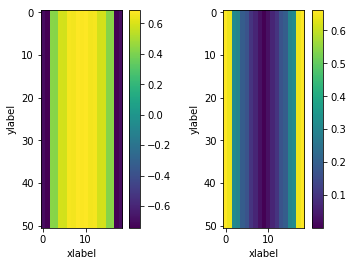

In [589]:
import numpy as np
from types import SimpleNamespace

sim = SimpleNamespace()
sim.res = 1 # Space resolution
sim.L, sim.W = 50, 20
sim.L_in, sim.W_in = int(sim.L/sim.res), int(sim.W/sim.res)  
sim.L_n,  sim.W_n  = sim.L_in + 1, sim.W_in + 1

sim.w = np.array([4, 1/4, 1, 1/4, 1, 1/4, 1, 1/4, 1])/9
sim.e = np.array([[0,0], [1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])

sim.iterations = 400

sim.dt = 1
sim.c = sim.res/sim.dt
sim.nu = 1
sim.tau = (6*(sim.nu*(sim.dt/sim.res**2)) + 1)/2
sim.m = 1
sim.P = 1

par = boltzmann_sim(sim)

In [329]:
plot_velocity_profile(sim, par)

ValueError: x and y must have same first dimension, but have shapes (20,) and (19,)

In [ ]:
# replaced by tensor dot in code 
np.shape(np.mean(np.reshape(par.n,par.rho (21, 6, 9, 1)) * sim.e, axis = 2))

In [ ]:
print(par.u)

In [ ]:
print(par.rho[0:5,0:5])

In [ ]:
np.zeros((5,3,2))

In [ ]:
np.zeros((5,3))

In [ ]:
print(par.u[0:5,0:3,:])

In [ ]:
print(np.shape(par.u[0:5,0:3,:]))

In [ ]:
Test_u = par.u[0:5,0:3,:].reshape(2,5,3)
#print(Test)
Test_rho = par.rho[0:5,0:3]

In [ ]:
Test_ratio = Test_u/Test_rho
print(Test_ratio)
Test_ratio.reshape(5,3,2)

In [ ]:
Test_u2 = np.zeros((5,3,2),dtype=float)
for i in range(2):
    Test_u2[:,:,i] = par.u[0:5,0:3,i]/par.rho[0:5,0:3]

In [ ]:
print(Test_u2)

In [37]:
np.shape(np.arange(sim.W_in))

(50,)

In [36]:
np.arange(sim.W_in)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [35]:
np.shape(par.u[0,1:sim.W_in,1])

(49,)

In [15]:
sim.W_in

50

In [21]:
np.shape(par.u[0,:,1])

(51,)

In [ ]:
1:50